In [1]:
%env CUDA_LAUNCH_BLOCKING = 1

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
a = int(input())

1


In [2]:
import os
import pandas as pd

In [3]:
data = pd.read_csv('birds_rev2/birds.csv')

In [4]:
#data.head()

In [4]:
data.shape, data[data['data set']=='train'].shape

((42114, 3), (39364, 3))

In [5]:
train_data = data[data['data set']=='train'][['filepaths', 'labels']]
valid_data = data[data['data set']=='valid'][['filepaths', 'labels']]
test_data = data[data['data set']=='test'][['filepaths', 'labels']]
valid_data.iloc[0], train_data.shape

(filepaths    valid/AFRICAN CROWNED CRANE/1.jpg
 labels                   AFRICAN CROWNED CRANE
 Name: 40739, dtype: object,
 (39364, 2))

In [6]:
train_data.shape, valid_data.shape, test_data.shape, valid_data.iloc[0][0]

((39364, 2), (1375, 2), (1375, 2), 'valid/AFRICAN CROWNED CRANE/1.jpg')

In [7]:
import torch

In [8]:
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

class mydataset(Dataset):
    def __init__(self, datafr, path, class_dict, transform = None):
        self.datafr = datafr
        self.path = path
        self.transform = transform
        self.class_dict = class_dict
    def __len__(self):
        return self.datafr.shape[0]
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = os.path.join(self.path, self.datafr.iloc[idx][0])
        img = plt.imread(img_path)
        label = self.class_dict[self.datafr.iloc[idx][1]]
        
        if self.transform :
            img = self.transform(img)
        return img, label

In [9]:
class_names = pd.read_csv('birds_rev2/class_dict.csv')
#class_names[272:277]

In [10]:
class_dict = {}
for i in range(275):
    class_dict[class_names.loc[i][1]] = i
#class_dict

In [11]:
import torchvision.transforms as transforms
train_dataset = mydataset(datafr = train_data, path = 'birds_rev2/', class_dict = class_dict, transform = transforms.Compose([transforms.ToTensor(),transforms.RandomResizedCrop(227, scale = (0.8, 0.8), ratio = (1, 1))]))

In [13]:
train_dataset[0][0].cuda().shape

C:\Users\saias\anaconda3\envs\pytor\lib\site-packages\torchvision\transforms\functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


torch.Size([3, 227, 227])

C:\Users\saias\anaconda3\envs\pytor\lib\site-packages\torchvision\transforms\functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


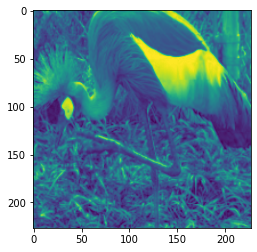

In [12]:
plt.imshow((train_dataset[0][0][2]))

In [13]:
valid_dataset = mydataset(datafr = valid_data, path = 'birds_rev2/', class_dict = class_dict, transform = transforms.Compose([transforms.ToTensor(),transforms.RandomResizedCrop(227, scale = (0.8, 0.8), ratio = (1, 1))]))

In [14]:
test_dataset = mydataset(datafr = test_data, path = 'birds_rev2/', class_dict = class_dict, transform = transforms.Compose([transforms.ToTensor(),transforms.RandomResizedCrop(227, scale = (0.8, 0.8), ratio = (1, 1))]))

In [15]:
valid_dataset[0][0].shape

torch.Size([3, 227, 227])

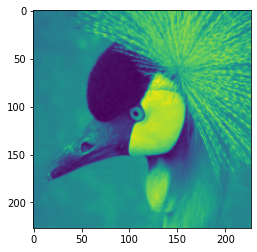

In [16]:
plt.imshow(test_dataset[0][0][0])

In [20]:
train_loader = DataLoader(train_dataset, batch_size = 15, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 15, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 15, shuffle = True)

In [21]:
a = iter(train_loader)
next(a)[0].shape[0]

15

In [22]:
import numpy as np
next(a)[1].shape, next(a)[0].shape

(torch.Size([15]), torch.Size([15, 3, 227, 227]))

In [17]:
rev_dict = {}
for i in class_dict:
    rev_dict[class_dict[i]] = i
#rev_dict

In [18]:
from torch.nn import Module
import torch.nn.functional as F
import torch.nn as nn

In [19]:
class net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1)
        self.bn1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, groups=2)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, groups=2)
        self.bn4 = nn.BatchNorm2d(384)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, groups=2)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(256*6*6, 6200)
        self.bn6 = nn.BatchNorm1d(6200)
        self.fc2 = nn.Linear(6200, 3200)
        self.bn7 = nn.BatchNorm1d(3200)
        self.fc3 = nn.Linear(3200, 275)
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = F.leaky_relu(self.bn6(self.fc1(torch.flatten(x, start_dim = 1))))
        x = F.leaky_relu(self.bn7(self.fc2(x)))
        x = self.fc3(x)
        return x

In [20]:
model = net()
model.load_state_dict(torch.load('./model6.pt'))
model.to(torch.device('cuda:0'))
print(model.parameters)
for i in model.parameters():
    print(i.shape)

<bound method Module.parameters of net(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (bn4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (

In [28]:
model(next(iter(train_loader))[0].to(torch.device('cuda:0')))

C:\Users\saias\anaconda3\envs\pytor\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[-15.5247, -12.8802, -21.1896,  ...,  -4.6496,  -7.4205,  -6.5699],
        [-17.3953, -20.4323, -24.0924,  ..., -13.0954, -10.8019, -13.6174],
        [ -1.6431,  -5.3780, -12.2530,  ...,  -5.4353,  -3.8628,  -9.9248],
        ...,
        [-11.6189, -31.4336, -21.6611,  ..., -24.0149, -15.6562, -22.2395],
        [ -3.4149,  -5.2650,  -4.2884,  ..., -13.0819, -10.8694,  -8.9488],
        [ -4.9811,  -6.7469,  -8.8068,  ...,  -6.5764,  -5.1172,  -4.0840]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [29]:
next(iter(train_loader))[0].to(torch.device('cpu'))

tensor([[[[0.5569, 0.5569, 0.5569,  ..., 0.4489, 0.5070, 0.5843],
          [0.5569, 0.5569, 0.5569,  ..., 0.4293, 0.4767, 0.5779],
          [0.5569, 0.5569, 0.5569,  ..., 0.4307, 0.4386, 0.5517],
          ...,
          [0.6812, 0.6812, 0.6820,  ..., 0.4398, 0.4630, 0.5038],
          [0.6770, 0.6776, 0.6810,  ..., 0.4429, 0.4469, 0.4480],
          [0.6706, 0.6738, 0.6800,  ..., 0.4545, 0.4641, 0.4706]],

         [[0.5725, 0.5725, 0.5725,  ..., 0.4645, 0.5227, 0.6000],
          [0.5725, 0.5725, 0.5725,  ..., 0.4450, 0.4924, 0.5936],
          [0.5725, 0.5725, 0.5725,  ..., 0.4464, 0.4552, 0.5729],
          ...,
          [0.6969, 0.6969, 0.6977,  ..., 0.4398, 0.4644, 0.5116],
          [0.6927, 0.6933, 0.6967,  ..., 0.4429, 0.4483, 0.4559],
          [0.6863, 0.6895, 0.6957,  ..., 0.4545, 0.4655, 0.4784]],

         [[0.6157, 0.6157, 0.6157,  ..., 0.5077, 0.5665, 0.6471],
          [0.6157, 0.6157, 0.6157,  ..., 0.4891, 0.5389, 0.6406],
          [0.6157, 0.6157, 0.6157,  ..., 0

In [22]:
train_loader = DataLoader(train_dataset, batch_size = 15, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 10, shuffle = True)


In [23]:
epochs = 15
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()

In [24]:
for g in optimizer.param_groups:
    g['lr'] = 0.00005

In [25]:
#model.train()
for e in range(epochs):
    train_loss = 0.
    valid_loss = 0.
    train_right = 0
    tot_train = 0
    i = 0
    print('---',e+1,'---')
    train_loader = DataLoader(train_dataset, batch_size = 15, shuffle = True)
    for x, y in train_loader:
        x, y = x.to(torch.device('cuda:0')), y.to(torch.device('cuda:0'))
        optimizer.zero_grad()
        preds = nn.functional.log_softmax(model(x), dim=1)
        train_right += (nn.functional.softmax(preds,dim = 1).argmax(1)==y).sum().item()
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*(y.shape[0])
        tot_train += (y.shape[0])
        
        x.cpu()
        y.cpu()
        torch.cuda.empty_cache()
        i += 1
        #if i%40 == 0:
        print(i)
        if i%400 == 0:
            #a = input()
            print(f'Train loss: {train_loss/tot_train}',f'Train accuracy: {(train_right/tot_train)*100}', sep = '\n')
        if i%80 == 0:
            valid_loss = 0
            valid_right = 0
            valid_tot = 0
            model.eval()
            v = 0
            for x, y in valid_loader:
                x, y = x.to(torch.device('cuda:0')), y.to(torch.device('cuda:0'))
                preds = model(x)
                loss = (loss_fn(preds, y))
                valid_right += (nn.functional.softmax(preds,dim = 1).argmax(1)==y).sum().item()
                valid_loss += loss.item()*(y.shape[0])
                valid_tot += (y.shape[0])
                v += 1
                x.cpu()
                y.cpu()
                torch.cuda.empty_cache()
                if v==20:
                    break
            print(f'Train loss: {train_loss/tot_train}, Valid loss: {valid_loss/valid_tot}',f'Valid accuracy: {(valid_right/valid_tot)*100}', sep = '\n')
            model.train()
            stop_here = input()

--- 1 ---


C:\Users\saias\anaconda3\envs\pytor\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
Train loss: 0.5932554449886084, Valid loss: 0.8051910758018493
Valid accuracy: 81.0


KeyboardInterrupt: Interrupted by user

In [26]:
tp = {}
for i in range(275):
    tp[i] = 0
fp = {}
for i in range(275):
    fp[i] = 0

In [27]:
a = torch.tensor([1,2])
a.tolist()

[1, 2]

In [28]:
valid_right = 0
valid_loss = 0
valid_tot = 0
model.eval()
for x, y in valid_loader:
    x, y = x.to(torch.device('cuda:0')), y.to(torch.device('cuda:0'))
    preds = model(x)
    pos = nn.functional.softmax(preds,dim = 1).argmax(1)
    valid_right += (pos==y).sum().item()
    valid_loss += (loss_fn(preds, y)).item()*(y.shape[0])
    valid_tot += (y.shape[0])
    #v += 1
    x.cpu()
    y.cpu()
    pos.cpu()
    pos = pos.tolist()
    y1 = y.tolist()
    for k,k1 in zip(pos, y1):
        if k==k1 :
            tp[k] += 1
        else:
            fp[k] += 1
    torch.cuda.empty_cache()
print(f'Train loss: {train_loss/tot_train}, Valid loss: {valid_loss/valid_tot}',f'Valid accuracy: {(valid_right/valid_tot)*100}', sep = '\n')

Train loss: 0.5932554449886084, Valid loss: 0.7256572518904101
Valid accuracy: 81.45454545454545


#### Accuracy of 81% is achieved. 

In [29]:
for i in range(275):
    print(f'TP: {tp[i]}, FP: {fp[i]}')

TP: 4, FP: 0
TP: 3, FP: 0
TP: 3, FP: 2
TP: 4, FP: 0
TP: 4, FP: 3
TP: 4, FP: 0
TP: 4, FP: 0
TP: 4, FP: 0
TP: 5, FP: 1
TP: 2, FP: 2
TP: 2, FP: 0
TP: 4, FP: 1
TP: 5, FP: 2
TP: 3, FP: 1
TP: 5, FP: 1
TP: 5, FP: 0
TP: 3, FP: 2
TP: 5, FP: 0
TP: 4, FP: 1
TP: 5, FP: 0
TP: 5, FP: 0
TP: 5, FP: 2
TP: 5, FP: 0
TP: 5, FP: 1
TP: 4, FP: 1
TP: 5, FP: 0
TP: 2, FP: 1
TP: 5, FP: 1
TP: 3, FP: 0
TP: 3, FP: 2
TP: 5, FP: 0
TP: 4, FP: 1
TP: 4, FP: 1
TP: 5, FP: 1
TP: 5, FP: 1
TP: 5, FP: 1
TP: 4, FP: 0
TP: 4, FP: 5
TP: 5, FP: 2
TP: 5, FP: 0
TP: 4, FP: 0
TP: 4, FP: 0
TP: 3, FP: 1
TP: 3, FP: 0
TP: 3, FP: 1
TP: 4, FP: 0
TP: 3, FP: 0
TP: 4, FP: 0
TP: 5, FP: 2
TP: 5, FP: 0
TP: 4, FP: 2
TP: 1, FP: 2
TP: 4, FP: 1
TP: 5, FP: 2
TP: 5, FP: 2
TP: 4, FP: 1
TP: 5, FP: 2
TP: 4, FP: 0
TP: 5, FP: 0
TP: 5, FP: 0
TP: 5, FP: 0
TP: 3, FP: 1
TP: 5, FP: 2
TP: 5, FP: 0
TP: 3, FP: 1
TP: 5, FP: 2
TP: 5, FP: 0
TP: 3, FP: 0
TP: 5, FP: 1
TP: 4, FP: 1
TP: 3, FP: 0
TP: 5, FP: 1
TP: 5, FP: 0
TP: 5, FP: 0
TP: 5, FP: 3
TP: 4, FP: 0
TP: 5, FP: 0